<b>Author : Aneesh Sathe<b>

## central model for the campus using model emsemble 

In [1]:
'''Importing Required Libraries'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob 
import warnings 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch 
from torch import nn
from torchinfo import summary
warnings.filterwarnings('ignore')

## three convLSTM models for the three different buildings 

### each model has specific hyperparameters

In [2]:
class ConvLSTM_A(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv = nn.Conv1d(in_channels = 7, out_channels = 64, kernel_size = 3, padding = 1, dtype=torch.float)
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.fc1 = nn.Linear(hidden_size, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, num_classes)

        
    
    def forward(self, x):
        conv_out = self.conv(x)
        conv_out = self.relu(conv_out)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn,cn) = self.lstm(conv_out.float(), (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        hn = self.relu(hn)
        out = self.fc1(hn)
        out = self.relu(out)
        out = self.fc2(out)
        return out 
        

In [3]:
class ConvLSTM_B(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv = nn.Conv1d(in_channels = 5, out_channels = 64, kernel_size = 3, padding = 1, dtype=torch.float)
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.1)
        self.fc1 = nn.Linear(hidden_size, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, num_classes)

        
    
    def forward(self, x):
        conv_out = self.conv(x)
        conv_out = self.relu(conv_out)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn,cn) = self.lstm(conv_out.float(), (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        hn = self.relu(hn)
        out = self.fc1(hn)
        out = self.relu(out)
        out = self.fc2(out)
        return out 
        

In [4]:
class ConvLSTM_C(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv = nn.Conv1d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1, dtype=torch.float)
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.1)
        self.fc1 = nn.Linear(hidden_size, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, num_classes)

        
    
    def forward(self, x):
        conv_out = self.conv(x)
        conv_out = self.relu(conv_out)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn,cn) = self.lstm(conv_out.float(), (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        hn = self.relu(hn)
        out = self.fc1(hn)
        out = self.relu(out)
        out = self.fc2(out)
        return out 
        

## loading pre-trained models from file directory

In [5]:
'''Initialise Model Instances'''
model_A = ConvLSTM_A(1,8,32,1)
model_B = ConvLSTM_B(1,8,32,1)
model_C = ConvLSTM_C(1,8,32,1)

In [6]:
'''Load the saved Parameters'''
model_A.load_state_dict(torch.load('saved_models_update/convLSTM-A.pth'))
model_B.load_state_dict(torch.load('saved_models_update/convLSTM-B.pth'))
model_C.load_state_dict(torch.load('saved_models_update/convLSTM-C.pth'))

<All keys matched successfully>

## loading new data

In [7]:
'''Loading New Data (Not Previously Seen by the Models)'''
data = sorted(glob.glob('ensemble_data/2022-11-*.csv'))

In [8]:
def make_data(data):
    month_dfs = []
    '''Read from File, Convert to Dataframe and Concatanate'''
    for _ in data:
        df = pd.read_csv(_, usecols = ['UpdateTime','Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc', 'Freq', 'PF'], index_col = False)
        df = df[['UpdateTime', 'Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc', 'PF', 'Freq' ]]
        df['UpdateTime'] = pd.to_datetime(df['UpdateTime'])
        month_dfs.append(df)
    month_df = pd.concat(month_dfs)
    '''Re-Sample the Data + Reduce Datapoints to Every Minute Interval'''
    resampled_data = month_df.set_index('UpdateTime')
    resampled_data = resampled_data.resample('1T').mean().interpolate(method='linear')
    resampled_data.reset_index(inplace=True)
    X, y = resampled_data.drop(columns = ['UpdateTime']), resampled_data.Freq.values
    return X, y
        
'''Preparing Data into Sequence for LSTM'''
def create_seq(X, y, seq_length):
    sequences_X = []
    sequences_y = []

    for i in range(len(X) - seq_length):
        sequences_X.append(X[i:i+seq_length])
        sequences_y.append(y[i+seq_length])

    seq_X = np.array(sequences_X)
    seq_y = np.array(sequences_y)
    return seq_X, seq_y


def scale_data(X, y):
    mm = MinMaxScaler()
    ss = StandardScaler()
    X_scaled = ss.fit_transform(X)
    y_scaled = mm.fit_transform(y.reshape(-1,1))
    return X_scaled, y_scaled, mm
    
    
    '''Converting Data into Torch Tensor for PyTorch Model'''
def make_tensor(X, y):
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X,y

def inverse_scaling(y_pred, y_true, scaler):
    y_pred = scaler.inverse_transform(y_pred)[:,0]
    y_true = scaler.inverse_transform(y_true)
    return y_pred, y_true

### splitting the data 3 ways, one for each model depending upon the kernel size of Conv1D Layer

In [9]:
Xa, ya = make_data(data)
Xa_scaled, ya_scaled, mma = scale_data(Xa, ya)

''' Predicting the Next 1 Time Step from Previous 7 Time Steps'''
in_step = 7 

Xa_ss, ya_mm = create_seq(Xa_scaled, ya_scaled, in_step) #split into data format for lstm training
Xa, ya = make_tensor(Xa_ss, ya_mm)


In [10]:
Xb, yb = make_data(data)
Xb_scaled, yb_scaled, mmb = scale_data(Xb, yb)

''' Predicting the Next 1 Time Step from Previous 5 Time Steps'''
in_step = 5 

Xb_ss, yb_mm = create_seq(Xb_scaled, yb_scaled, in_step) #split into data format for lstm training
Xb, yb = make_tensor(Xb_ss, yb_mm)


In [11]:
Xc, yc = make_data(data)
Xc_scaled, yc_scaled, mmc = scale_data(Xc, yc)

''' Predicting the Next 1 Time Step from Previous 3 Time Steps'''
in_step = 3 

Xc_ss, yc_mm = create_seq(Xc_scaled, yc_scaled, in_step) #split into data format for lstm training
Xc, yc = make_tensor(Xc_ss, yc_mm)


In [12]:
Xa.shape, Xb.shape, Xc.shape 

(torch.Size([43194, 7, 8]),
 torch.Size([43196, 5, 8]),
 torch.Size([43198, 3, 8]))

In [13]:
ya.shape, yb.shape, yc.shape

(torch.Size([43194, 1]), torch.Size([43196, 1]), torch.Size([43198, 1]))

In [16]:
'''Forward Pass through the prediction model'''
ya_pred = model_A(Xa.float())
yb_pred = model_B(Xb.float())
yc_pred = model_C(Xc.float())

In [17]:
'''Inverse Scale the Model Predictions to get Actual Predictions'''
ya_pred, ya_true = inverse_scaling(ya_pred.detach(), ya, mma)
yb_pred, yb_true = inverse_scaling(yb_pred.detach(), yb, mmb)
yc_pred, yc_true = inverse_scaling(yc_pred.detach(), yc, mmc)
ya_true, yb_true, yc_true = ya_true.squeeze(), yb_true.squeeze(), yc_true.squeeze()

In [33]:
'''Loss Functions to test Ensemble Model'''
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

def mse(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean((y_true - predictions) ** 2)

def mape(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    absolute_percentage_errors = np.abs((y_true - predictions) / y_true)
    mape = np.mean(absolute_percentage_errors) * 100
    return mape

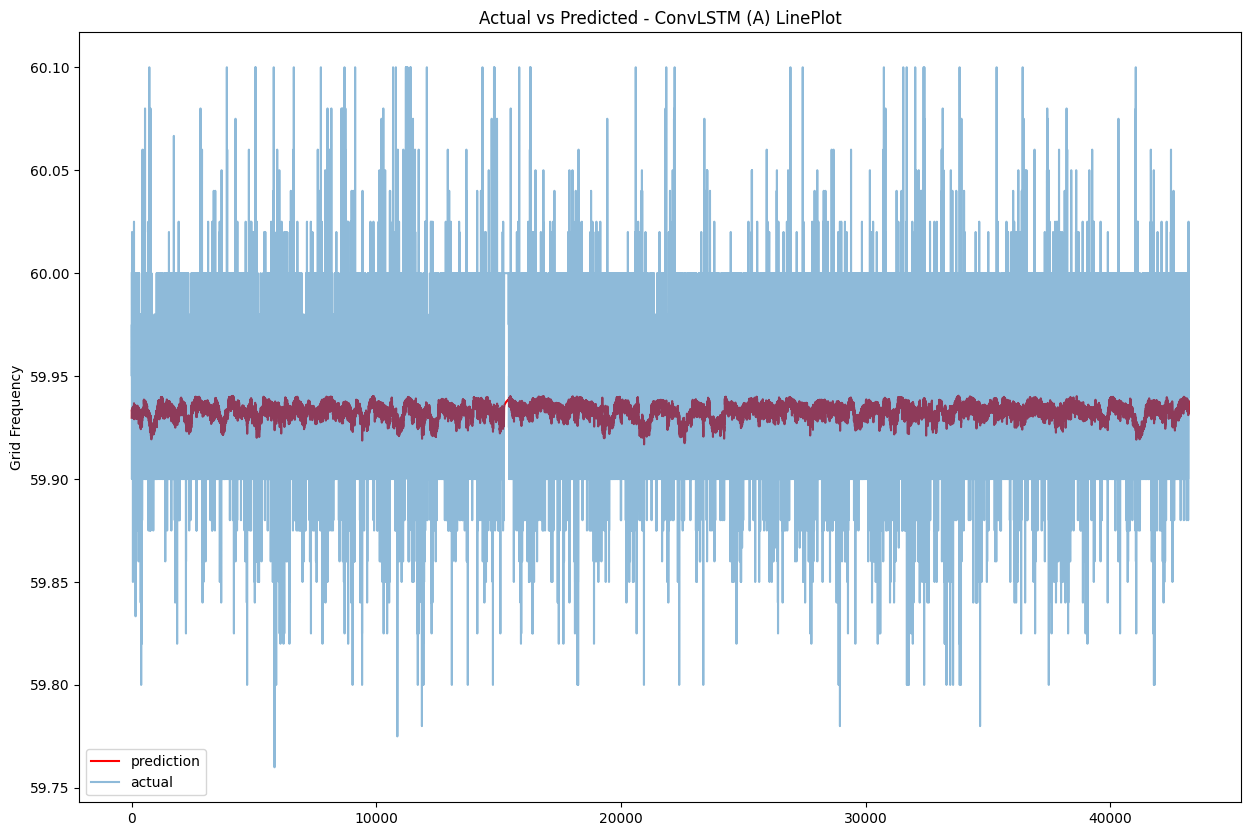

In [19]:
plt.figure(figsize = (15,10))
plt.plot(ya_pred, label = 'prediction', c='r')
plt.plot(ya_true, label = 'actual', alpha = 0.5)
plt.title('Actual vs Predicted - ConvLSTM (A) LinePlot')
plt.ylabel("Grid Frequency")
plt.legend()
plt.show()

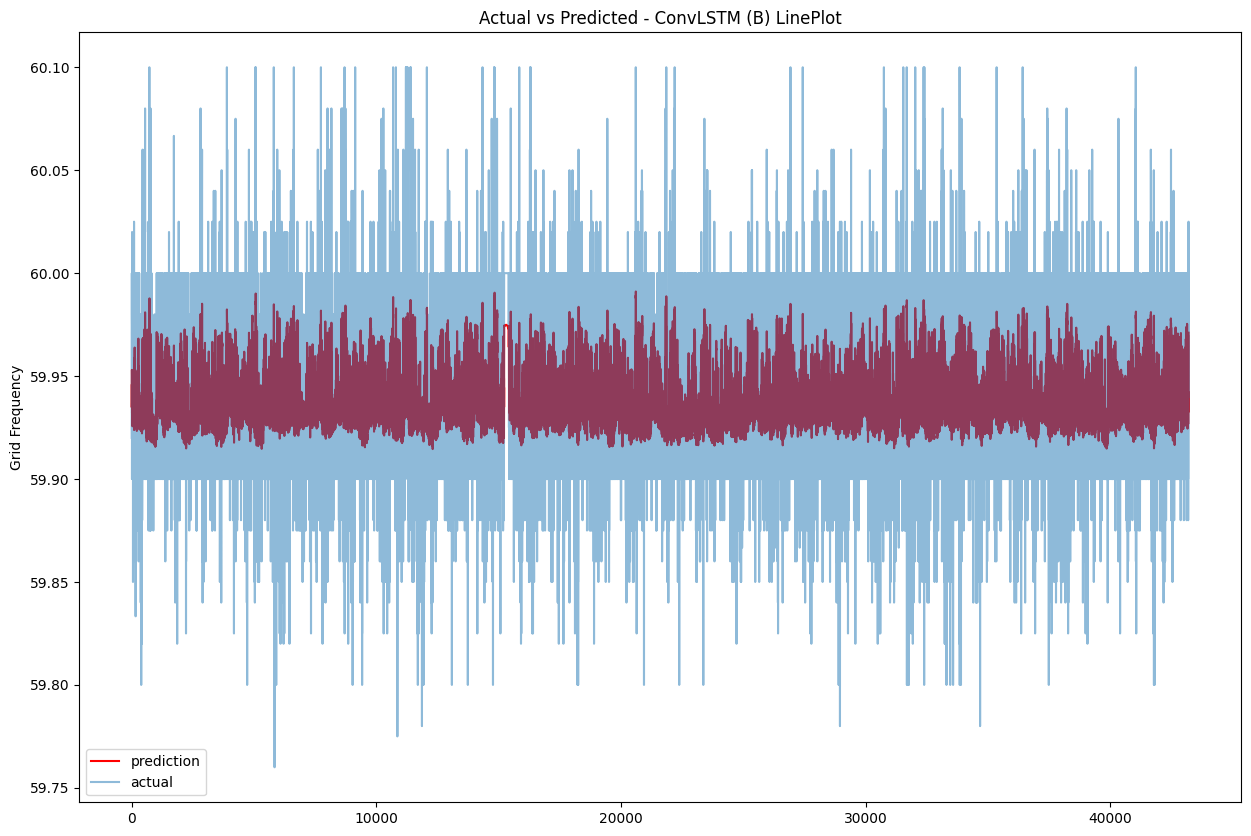

In [20]:
plt.figure(figsize = (15,10))
plt.plot(yb_pred, label = 'prediction', c='r')
plt.plot(yb_true, label = 'actual', alpha = 0.5)
plt.title('Actual vs Predicted - ConvLSTM (B) LinePlot')
plt.ylabel("Grid Frequency")
plt.legend()
plt.show()

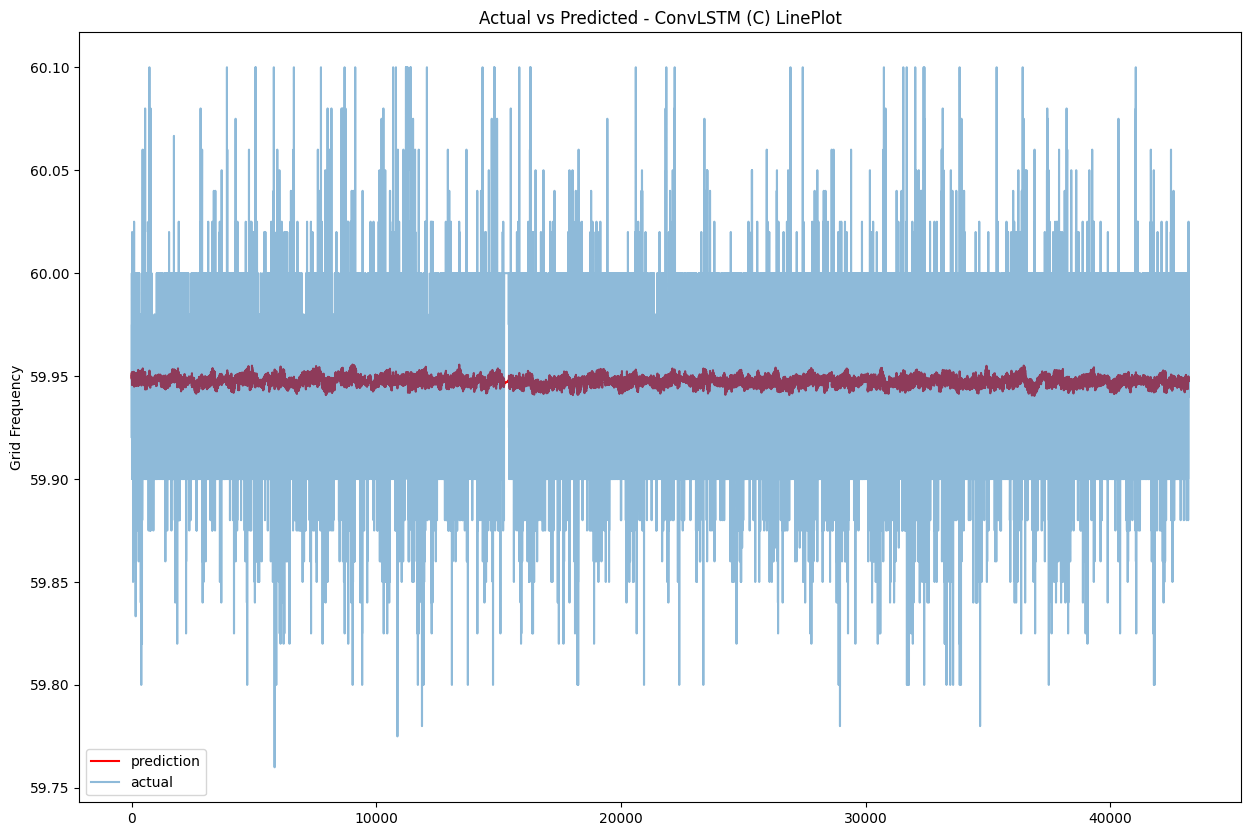

In [21]:
plt.figure(figsize = (15,10))
plt.plot(yc_pred, label = 'prediction', c='r')
plt.plot(yc_true, label = 'actual', alpha = 0.5)
plt.title('Actual vs Predicted - ConvLSTM (C) LinePlot')
plt.ylabel("Grid Frequency")
plt.legend()
plt.show()

In [22]:
ya_true.shape, yb_true.shape

((43194,), (43196,))

In [23]:
ya_pred.shape, yb_pred.shape

((43194,), (43196,))

## model ensembling

In [24]:
'''Padding the predictions with 0 to ensure all predictions have equal length'''
max_len = max([len(ya_pred), len(yb_pred), len(yc_pred)])
pad_a = (0, max_len - len(ya_pred))
pad_b = (0, max_len - len(yb_pred))
ya_pred = np.pad(ya_pred, pad_a, mode='constant', constant_values=0)
yb_pred = np.pad(yb_pred, pad_b, mode='constant', constant_values=0)
ya_true = np.pad(ya_true, pad_a, mode='constant', constant_values=0)
yb_true = np.pad(yb_true, pad_b, mode='constant', constant_values=0)

In [26]:
'''Replace the 0 values with values of the longest predictions in each respective index'''
yb_pred[-pad_b[1]:] = yc_pred[-pad_b[1]:]
ya_pred[-pad_a[1]:] = yc_pred[-pad_a[1]:]
ya_true[-pad_a[1]:] = yc_true[-pad_a[1]:]
yb_true[-pad_a[1]:] = yc_true[-pad_a[1]:]

In [28]:
ya_true.shape, ya_pred.shape, yc_pred.shape

((43198,), (43198,), (43198,))

In [29]:
'''variable weights for the ensemble model, can be tuned to obtain highest accuracy'''
w_a = 0.3
w_b = 0.4
w_c = 0.3

ensemble_pred = (w_a * ya_pred) + (w_b * yb_pred) + (w_c * yc_pred)

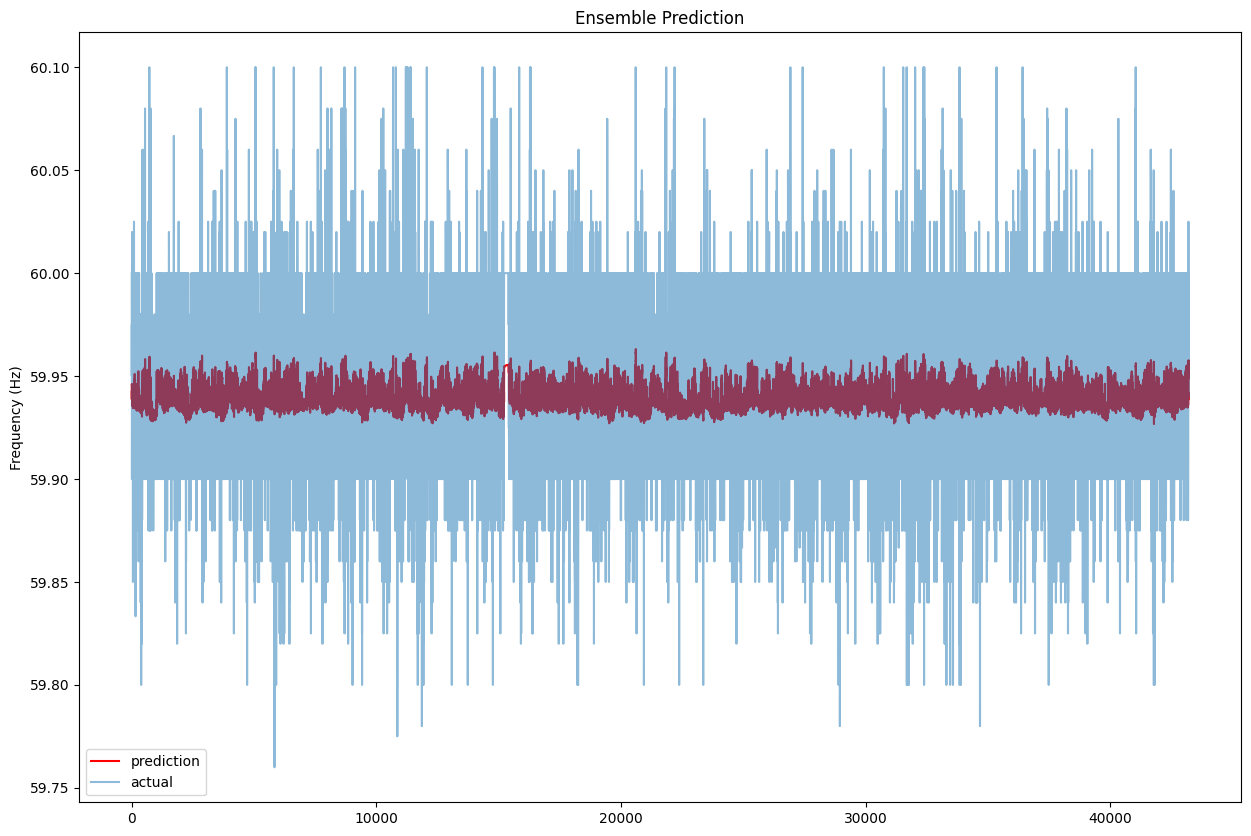

In [30]:
plt.figure(figsize = (15,10))
plt.plot(ensemble_pred, label = 'prediction', c='r')
plt.plot(ya_true, label = 'actual', alpha = 0.5)
plt.title('Ensemble Prediction')
plt.ylabel("Frequency (Hz)")
plt.legend()
plt.savefig('update-figures/ensemble-pred')
plt.show()

In [34]:
'''Calculating Aggregated MSE, MAE & MAPE Loss for the Ensemble Model'''
mse_a = mse(ya_true,ya_pred)
mse_b = mse(yb_true,yb_pred)
mse_c = mse(yc_true,yc_pred)
ensemble_mse = mse(yc_true.squeeze(),ensemble_pred)

mae_a = mae(ya_true,ya_pred)
mae_b = mae(yb_true,yb_pred)
mae_c = mae(yc_true,yc_pred)
ensemble_mae = mae(yc_true.squeeze(),ensemble_pred)

mape_a = mape(ya_true,ya_pred)
mape_b = mape(yb_true,yb_pred)
mape_c = mape(yc_true,yc_pred)
ensemble_mape = mape(yc_true,ensemble_pred)

In [35]:
print('MSE Loss:')
print('A : ', mse_a)
print('B : ', mse_b)
print('C : ', mse_c)
print('Ensemble:', ensemble_mse)
print('\nMAE Loss:')
print('A : ', mae_a)
print('B : ', mae_b)
print('C : ', mae_c)
print('Ensemble:', ensemble_mae)
print('\nMAPE Loss:')
print('A : ', mape_a)
print('B : ', mape_b)
print('C : ', mape_c)
print('Ensemble:', ensemble_mape)

MSE Loss:
A :  0.0016050974255398572
B :  0.001414773070030996
C :  0.001535232912655372
Ensemble: 0.0014001192219641443

MAE Loss:
A :  0.032767588544087276
B :  0.030919994863119832
C :  0.032509306162854794
Ensemble: 0.031074915549932847

MAPE Loss:
A :  0.05465213434279073
B :  0.05157445321699349
C :  0.054233891245951016
Ensemble: 0.051834021828321586
